In [1]:
import pandas as pd
import numpy as np
import os
import requests
from scipy.stats import zscore
from mygene import MyGeneInfo
from sklearn.preprocessing import QuantileTransformer
import collections
def tree(): return collections.defaultdict(tree)
import pickle 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import ttest_rel
from sklearn.decomposition import NMF
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import ttest_ind
import statsmodels.api as sm
import gseapy as gp

# Data pre-processing

In [2]:
# 1. Loading dataset 
data_dir = "/BiO2/Research/ipmi/gastric_cancer/RNAseq_RSEM"  # Input your directory
data_files = [f for f in os.listdir(data_dir) if "results" in f]
data_list = {}

for file in data_files:
    file_path = os.path.join(data_dir, file)
    data = pd.read_csv(file_path, sep="\t")
    data_name = file.replace("_rsem_genes_original_results", "")
    data_list[data_name] = data

# 2. Retaining genes with TPM >= 1 in at least 50% of patients
combined_data = pd.concat(data_list.values(), keys=data_list.keys(), names=['Dataset'])
filtered_data = combined_data.groupby('gene_id').filter(lambda x: (x['TPM'] >= 1).mean() >= 0.5)
data_list = {k: v.reset_index(drop=True) for k, v in filtered_data.groupby('Dataset')}

# 3. Calculate Log2(TPM+1)
def log2_transform(data):
    return np.log2(data + 1)
for key in data_list:
    data_list[key]['TPM'] = log2_transform(data_list[key]['TPM'])
    data_list[key].rename(columns={'TPM': 'log2(TPM+1)'}, inplace=True)
    data_list[key] = data_list[key][['gene_id', 'log2(TPM+1)']]

In [3]:
# 4. Fetch gene names based on gene IDs using MyGene
def fetch_gene_names(gene_ids):
    mg = MyGeneInfo()
    gene_info = mg.querymany(gene_ids, scopes='ensembl.gene', fields='symbol', species='human')
    gene_names = {gene['query']: gene.get('symbol', 'NA') for gene in gene_info if 'query' in gene}
    return gene_names

gene_ids = data_list[list(data_list.keys())[0]]['gene_id'].tolist()
gene_names_dict = fetch_gene_names(gene_ids)

data_list_gene_names = {}
for key, df in data_list.items():
    df['gene_name'] = df['gene_id'].map(gene_names_dict)
    data_list_gene_names[key] = df[['gene_id', 'gene_name', 'log2(TPM+1)']]

1 input query terms found dup hits:	[('ENSG00000230373', 2)]
321 input query terms found no hit:	['ENSG00000005955', 'ENSG00000006074', 'ENSG00000006075', 'ENSG00000006114', 'ENSG00000017621', 'ENS


In [4]:
# 5. Quantile normalization of Log2(TPM+1)
TPM_matrix = pd.concat([df['log2(TPM+1)'] for df in data_list_gene_names.values()], axis=1)
TPM_matrix.columns = data_list_gene_names.keys()

qt = QuantileTransformer()
normalized_matrix = qt.fit_transform(TPM_matrix)

norm_data_list_final = {}
for i, key in enumerate(data_list_gene_names.keys()):
    norm_data_list_final[key] = data_list_gene_names[key].copy()
    norm_data_list_final[key]['log2(TPM+1)'] = normalized_matrix[:, i]

In [5]:
# 6. Calculate log2(TPM+1) fold change for Normal vs Tumor

fold_change_list = {}
odd_patients = range(1, 5760, 2)

for patient in odd_patients:
    normal_id = f"{patient}N"
    tumor_id = f"{patient + 1}T"

    if normal_id in norm_data_list_final and tumor_id in norm_data_list_final:
        normal_sample = norm_data_list_final[normal_id]
        tumor_sample = norm_data_list_final[tumor_id]

        fold_change = tumor_sample['log2(TPM+1)'] - normal_sample['log2(TPM+1)']

        if not fold_change.isna().all():
            result_id = f"{patient}N/{patient + 1}T"
            fold_change_list[result_id] = pd.DataFrame({
                'gene_id': normal_sample['gene_id'],
                'gene_name': normal_sample['gene_name'],
                'Fold_change_log2_TPM_plus_1': fold_change
            })

In [6]:
# 7. Merge all fold change DataFrames and create a matrix
merged_df = pd.concat(fold_change_list.values(), keys=fold_change_list.keys())
merged_df = merged_df.reset_index()[["level_0", "gene_id", "gene_name", "Fold_change_log2_TPM_plus_1"]].rename(columns={"level_0":"sample_id"})

In [7]:
merged_df.head(2)

,sample_id,gene_id,gene_name,Fold_change_log2_TPM_plus_1
0,13N/14T,ENSG00000000003,TSPAN6,-0.141602
1,13N/14T,ENSG00000000419,DPM1,0.029655


In [8]:
input_data = merged_df[["gene_id", "sample_id", "Fold_change_log2_TPM_plus_1"]].pivot(index='gene_id', columns='sample_id', values='Fold_change_log2_TPM_plus_1')

In [9]:
medians = input_data.median(axis=1)
absolute_deviation = (input_data.sub(medians, axis=0)).abs()
mad_values = absolute_deviation.median(axis=1)

# NMF clustering

In [10]:
def preprocess_data(data):
    scaler = MinMaxScaler()
    if isinstance(data, pd.DataFrame):
        scaled_data = pd.DataFrame(
            scaler.fit_transform(data),
            index=data.index,
            columns=data.columns
        )
    else:
        scaled_data = scaler.fit_transform(data)
    return scaled_data

def calculate_consensus_matrix(data, n_components, n_runs=50, random_state=42):
    preprocessed_data = preprocess_data(data)
    
    n_samples = preprocessed_data.shape[1]
    connectivity_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_runs):
        nmf = NMF(n_components=n_components, 
                  init='random', 
                  random_state=random_state+i,
                  max_iter=1000)
        W = nmf.fit_transform(preprocessed_data.T)

        assignments = W.argmax(axis=1)
        
        for i in range(n_samples):
            for j in range(i+1, n_samples):
                if assignments[i] == assignments[j]:
                    connectivity_matrix[i, j] += 1
                    connectivity_matrix[j, i] += 1
    consensus_matrix = connectivity_matrix / n_runs
    return consensus_matrix

def calculate_cophenetic_coefficient(consensus_matrix):
    consensus_distances = 1 - consensus_matrix
    linkage_matrix = linkage(consensus_distances[np.triu_indices(consensus_distances.shape[0], k=1)], 
                           method='average')
    coph_corr, _ = cophenet(linkage_matrix, pdist(consensus_distances))
    return coph_corr

def perform_nmf_analysis(data, k_range=range(2, 7), n_runs=50):
    results = []
    all_silhouette_scores = {}
    preprocessed_data = preprocess_data(data)
    
    for k in k_range:
        print(f"\nAnalyzing k={k}...")

        consensus_matrix = calculate_consensus_matrix(data, n_components=k, n_runs=n_runs)
        coph_coeff = calculate_cophenetic_coefficient(consensus_matrix)

        nmf = NMF(n_components=k, init='random', random_state=42, max_iter=1000)
        W = nmf.fit_transform(preprocessed_data.T)
        H = nmf.components_
        cluster_labels = W.argmax(axis=1)

        sample_silhouette_values = silhouette_samples(W, cluster_labels)
        avg_silhouette = np.mean(sample_silhouette_values)

        results.append({
            'k': k,
            'cophenetic_coefficient': coph_coeff,
            'silhouette_score': avg_silhouette
        })

        if isinstance(data, pd.DataFrame):
            k_results = pd.DataFrame({
                'Sample': data.columns,
                'Cluster': cluster_labels,
                'Silhouette_Score': sample_silhouette_values
            })
        else:
            k_results = pd.DataFrame({
                'Sample': [f'Sample_{i}' for i in range(len(cluster_labels))],
                'Cluster': cluster_labels,
                'Silhouette_Score': sample_silhouette_values
            })

        all_silhouette_scores[k] = k_results

        print(f"K = {k}:")
        print(f"Cophenetic Coefficient = {coph_coeff:.4f}")
        print(f"Average Silhouette Score = {avg_silhouette:.4f}")
        print("Cluster sizes:", pd.Series(cluster_labels).value_counts().to_dict())

        for cluster in range(k):
            cluster_sil_scores = k_results[k_results['Cluster'] == cluster]['Silhouette_Score']
            print(f"Cluster {cluster} average silhouette score: {cluster_sil_scores.mean():.4f}")
    
    return results, all_silhouette_scores

def get_best_clustering(data, k, random_state=42):

    preprocessed_data = preprocess_data(data)

    nmf = NMF(n_components=k, init='random', random_state=random_state, max_iter=1000)
    W = nmf.fit_transform(preprocessed_data.T)
    H = nmf.components_
    
    cluster_assignments = W.argmax(axis=1)
    sample_silhouette_values = silhouette_samples(W, cluster_assignments)
    
    if isinstance(data, pd.DataFrame):
        clustering_results = pd.DataFrame({
            'Sample': data.columns,
            'Cluster': cluster_assignments,
            'Silhouette_Score': sample_silhouette_values
        })
    else:
        clustering_results = pd.DataFrame({
            'Sample': [f'Sample_{i}' for i in range(len(cluster_assignments))],
            'Cluster': cluster_assignments,
            'Silhouette_Score': sample_silhouette_values
        })
    
    return clustering_results, W, H

In [11]:
final_result = tree()
for i in [0.1, 0.2, 0.3]:
    percent = str(i*100) + "%"
    i = 1 - i
    threshold = mad_values.quantile(i)
    top_genes = mad_values[mad_values > threshold]
    M10 = input_data.loc[top_genes.index]
    results, all_silhouette_scores = perform_nmf_analysis(M10, k_range=range(2, 7))
    final_result[percent]["cophenetic"] = results
    final_result[percent]["silhouette"] = all_silhouette_scores


Analyzing k=2...
K = 2:
Cophenetic Coefficient = 0.9656
Average Silhouette Score = 0.5509
Cluster sizes: {1: 55, 0: 25}
Cluster 0 average silhouette score: 0.5259
Cluster 1 average silhouette score: 0.5622

Analyzing k=3...
K = 3:
Cophenetic Coefficient = 0.8788
Average Silhouette Score = 0.3052
Cluster sizes: {0: 48, 2: 19, 1: 13}
Cluster 0 average silhouette score: 0.2824
Cluster 1 average silhouette score: 0.5377
Cluster 2 average silhouette score: 0.2038

Analyzing k=4...
K = 4:
Cophenetic Coefficient = 0.8934
Average Silhouette Score = 0.2862
Cluster sizes: {3: 28, 0: 24, 2: 16, 1: 12}
Cluster 0 average silhouette score: 0.2078
Cluster 1 average silhouette score: 0.3336
Cluster 2 average silhouette score: 0.3719
Cluster 3 average silhouette score: 0.2840

Analyzing k=5...
K = 5:
Cophenetic Coefficient = 0.7849
Average Silhouette Score = 0.1642
Cluster sizes: {0: 30, 1: 19, 4: 12, 3: 11, 2: 8}
Cluster 0 average silhouette score: 0.1639
Cluster 1 average silhouette score: 0.2421
Cl

In [12]:
df_list = []
for i in final_result:
    for dic in final_result[i]["cophenetic"]:
        k = dic["k"]
        cophenetic = dic["cophenetic_coefficient"]
        df = pd.DataFrame({"percent":i, "k":k, "cophenetic_score":cophenetic}, index = [0])
        df_list.append(df)
df = pd.concat(df_list)

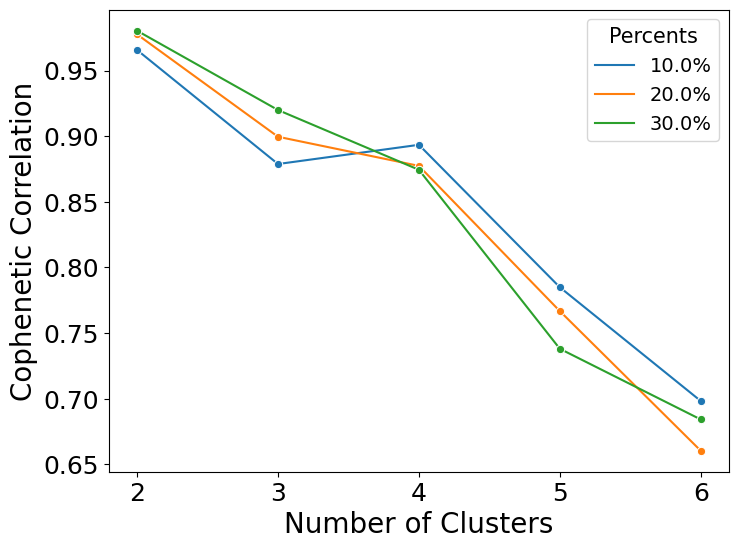

In [13]:
df['percent'] = df['percent'].astype('category')

plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='k', y='cophenetic_score', hue='percent', marker='o')

plt.xticks(ticks=df['k'].unique(), fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('K', fontsize=22)
plt.ylabel('Cophenetic Score', fontsize=22)

# plt.title('Cophenetic Correlation plot for mRNA data (MinMaxScaling)', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=20)
plt.ylabel('Cophenetic Correlation', fontsize=20)

plt.legend(title='Percents', title_fontsize='15', fontsize='14')
# plt.savefig("path/to/plot/dir/Cophenetic_correlation_plot_mRNA_minmaxscaling.pdf", bbox_inches='tight')

plt.show()

In [15]:
# modify the result for the iCluster
for percent in ['10.0%', '20.0%', '30.0%']:
    for i in final_result[percent]["silhouette"]:
        out = pd.DataFrame(final_result[percent]["silhouette"][i])
        out["order"] = out["Sample"].str.split("N").str[0].astype(int)
        out['N'] = out['Sample'].str.split("/").str[0].str.split("N").str[0]
        out['T'] = out['Sample'].str.split("/").str[1].str.split("T").str[0]
        out["Sample"] = "N" + out["N"]+"T"+out["T"]
        out = out.sort_values(by='order')
        out = out[["Sample", "Cluster"]]
        out["Cluster"] = out["Cluster"].astype(str)
        out["Cluster"] = "mrna_cluster"+out["Cluster"]
        result = out.pivot_table(index='Cluster', columns='Sample', aggfunc=lambda x: 1, fill_value=0)
        result = result.reset_index()
        # result.to_csv(f"/path/to/ouput/dir/mrna_percent_{percent}_clusternum_{i}_nmf_clustering_result.csv", index = False, header = True)

# Consensus matrix

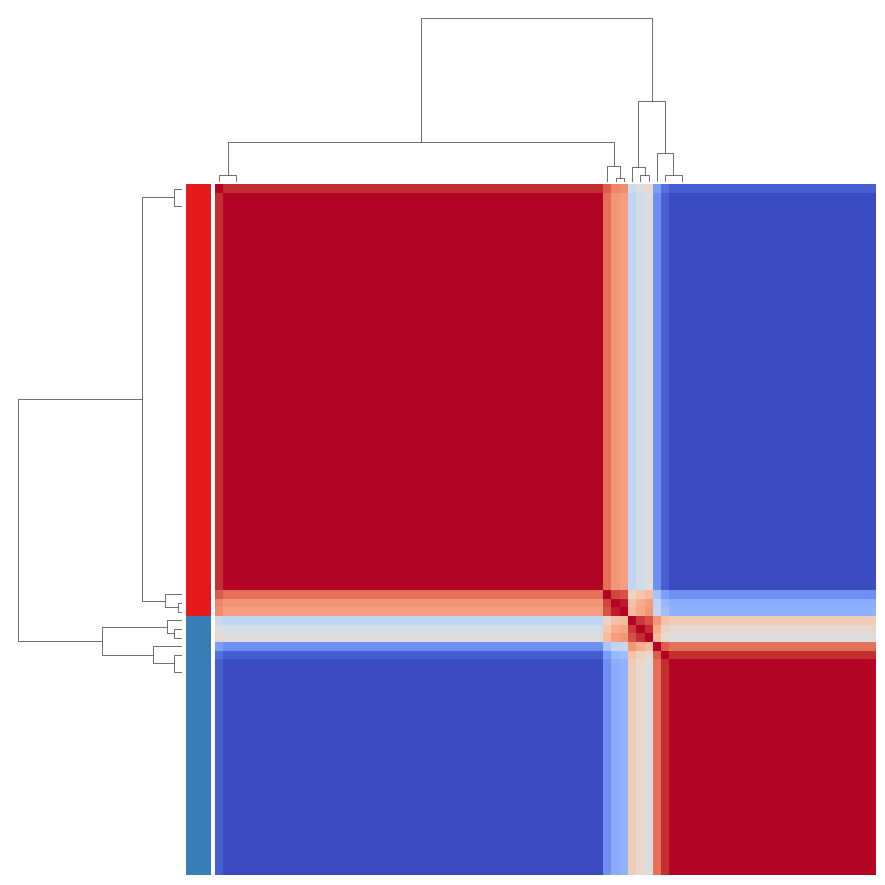

In [16]:
def calculate_consensus_matrix(data, n_components=2, n_runs=50, random_state=42):
    data = preprocess_data(data)
    n_samples = data.shape[1]
    consensus_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_runs):
        nmf = NMF(n_components=n_components, init='random', random_state=random_state + i, max_iter=1000)
        W = nmf.fit_transform(data.T) 

        cluster_assignments = W.argmax(axis=1)
        for j in range(n_samples):
            for k in range(n_samples):
                if cluster_assignments[j] == cluster_assignments[k]:
                    consensus_matrix[j, k] += 1
                    
    consensus_matrix /= n_runs

    np.fill_diagonal(consensus_matrix, 1.0)
    
    return consensus_matrix, cluster_assignments

i = 0.1
percent = str(i*100) + "%"
i = 1 - i
threshold = mad_values.quantile(i)
top_genes = mad_values[mad_values > threshold]
M10 = input_data.loc[top_genes.index]

consensus_matrix, final_cluster_assignments = calculate_consensus_matrix(M10, n_components=2, n_runs=50, random_state=42)

def add_row_color_mapping(heatmap_data, final_cluster_assignments):
    unique_groups = list(set(final_cluster_assignments))
    color_palette = sns.color_palette("Set1", n_colors=len(unique_groups))
    group_colors = {group: color for group, color in zip(unique_groups, color_palette)}

    row_colors = pd.Series(final_cluster_assignments, index=heatmap_data.columns).map(group_colors)
    
    return row_colors

def plot_heatmap_with_row_colors(heatmap_data, consensus_matrix, final_cluster_assignments):
    row_colors = add_row_color_mapping(heatmap_data, final_cluster_assignments)

    g = sns.clustermap(consensus_matrix, annot=False, fmt=".2f", cmap="coolwarm",  
                       xticklabels=heatmap_data.columns, yticklabels=heatmap_data.columns, 
                       row_colors=row_colors.values, cbar_pos=None)
    g.ax_heatmap.set_xticklabels([])  
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticks([])  
    g.ax_heatmap.set_yticks([]) 
    
    # plt.title('Consensus Matrix Heatmap')
    # plt.savefig("/path/to/plot/dir/Consensus_matrix_heatmap_mRNA_minmaxscaling.pdf", bbox_inches='tight')
    plt.show()

plot_heatmap_with_row_colors(M10, consensus_matrix, final_cluster_assignments)

# Silhouette score

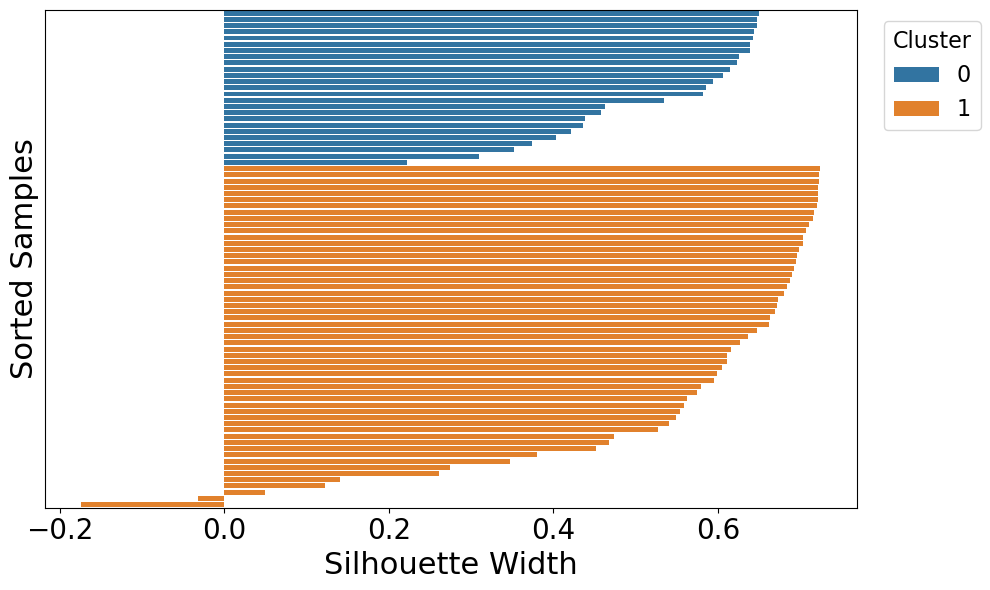

In [17]:
silhouette_scores = final_result['10.0%']["silhouette"]
df = pd.DataFrame(silhouette_scores[2])

df_sorted = df.sort_values(by=['Cluster', 'Silhouette_Score'], ascending=[True, False])
df_sorted['Cluster'] = df_sorted['Cluster'].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x='Silhouette_Score', y='Sample', hue='Cluster', dodge=False)

plt.yticks([])
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left', prop={'size': 16}, title_fontsize='16')
plt.xlabel('Silhouette Width', fontsize=22)
plt.ylabel('Sorted Samples', fontsize=22)
plt.xticks(fontsize=20)

plt.tight_layout()
# plt.savefig('/path/to/plot/dir/RNA_cluster2_silhouette_score.pdf', bbox_inches='tight')
plt.show()

# Signature genes

In [24]:
def calculate_consensus_matrix(data, n_components, n_runs=50, random_state=42):
    preprocessed_data = preprocess_data(data)
    
    n_samples = preprocessed_data.shape[1]
    connectivity_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_runs):
        nmf = NMF(n_components=n_components, 
                  init='random', 
                  random_state=random_state+i,
                  max_iter=1000)
        W = nmf.fit_transform(preprocessed_data.T)

        assignments = W.argmax(axis=1)

        for i in range(n_samples):
            for j in range(i+1, n_samples):
                if assignments[i] == assignments[j]:
                    connectivity_matrix[i, j] += 1
                    connectivity_matrix[j, i] += 1

    consensus_matrix = connectivity_matrix / n_runs
    return consensus_matrix

In [25]:
results, silhouette_scores = perform_nmf_analysis(M10, k_range=range(2, 3))


Analyzing k=2...
K = 2:
Cophenetic Coefficient = 0.9656
Average Silhouette Score = 0.5509
Cluster sizes: {1: 55, 0: 25}
Cluster 0 average silhouette score: 0.5259
Cluster 1 average silhouette score: 0.5622


In [26]:
cluster = pd.DataFrame(silhouette_scores[2])
cluster['Cluster'] = cluster['Cluster'].replace({0: "RNA1", 1: "RNA2"})
cluster = cluster.loc[cluster["Silhouette_Score"]>0]
subtype_df = cluster[["Sample", "Cluster"]].reset_index(drop = True)

In [27]:
log2fc_df = M10[subtype_df.Sample.tolist()]

In [28]:
cluster_0_samples = subtype_df[subtype_df['Cluster'] == "RNA1"]['Sample'].values
cluster_1_samples = subtype_df[subtype_df['Cluster'] == "RNA2"]['Sample'].values

results = []
for gene in log2fc_df.index:
    group_0 = log2fc_df.loc[gene, cluster_0_samples]
    group_1 = log2fc_df.loc[gene, cluster_1_samples]

    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

    median_ratio = group_0.median() / group_1.median() if group_1.median() != 0 else float('inf')

    results.append({'gene': gene, 'p_value': p_value, 'median_ratio': median_ratio,
                    'median_group_0': group_0.median(), 'median_group_1': group_1.median()})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
signature_genes = results_df[results_df['p_value'] < 0.05]

# Filter based on median values
filtered_signature_genes_0 = signature_genes[
    (signature_genes['median_group_0'] > 0) &                # Median of subtype > 0
    (signature_genes['median_group_1'] < 0) &                # Median of remaining patients < 0
    (signature_genes['median_group_0'] > signature_genes['median_group_1'])  # Median of subtype > median of remaining patients
]
filtered_signature_genes_1 = signature_genes[
    (signature_genes['median_group_1'] > 0) &                # Median of subtype > 0
    (signature_genes['median_group_0'] < 0) &                # Median of remaining patients < 0
    (signature_genes['median_group_1'] > signature_genes['median_group_0'])  # Median of subtype > median of remaining patients
]

In [29]:
filtered_signature_genes = filtered_signature_genes_0["gene"].tolist()+filtered_signature_genes_1["gene"].tolist()
heatmap_data = log2fc_df.loc[filtered_signature_genes, :].T
sample_groups = len(filtered_signature_genes_0["gene"].tolist())*["RNA1"]+len(filtered_signature_genes_1["gene"].tolist())*["RNA2"]
heatmap_data = heatmap_data.reindex(index=cluster.sort_values("Cluster")["Sample"].tolist())
sample_groups2 = cluster.sort_values("Cluster")["Cluster"].tolist()

<Figure size 1200x800 with 0 Axes>

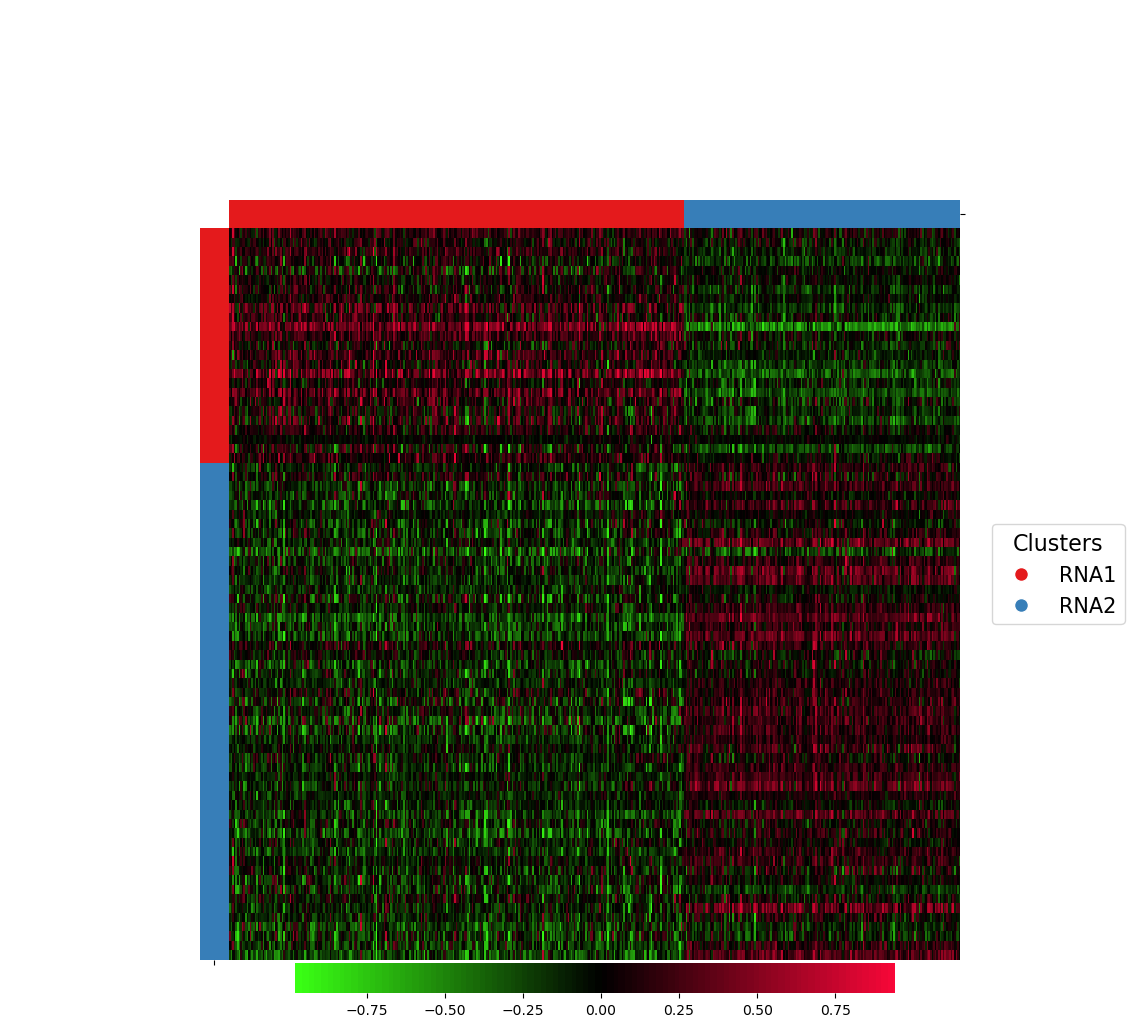

In [30]:
unique_groups = list(set(sample_groups))
color_palette = sns.color_palette("Set1", n_colors=len(unique_groups))
group_colors = {group: color for group, color in zip(unique_groups, color_palette)}

col_colors = pd.Series(sample_groups, index=heatmap_data.columns).map(group_colors)

unique_groups = list(set(sample_groups2))
color_palette = sns.color_palette("Set1", n_colors=len(unique_groups))
group_colors = {group: color for group, color in zip(unique_groups, color_palette)}

row_colors = pd.Series(sample_groups2, index=heatmap_data.index).map(group_colors)

colors = ['#39FF14', 'black', '#FF073A']  
n_bins = 100  
cmap = LinearSegmentedColormap.from_list("green_black_red", colors, N=n_bins)

plt.figure(figsize=(12, 8))  
g = sns.clustermap(
    heatmap_data,
    cmap=cmap, 
    center=0,  
    col_colors=col_colors, 
    row_colors=row_colors, 
    xticklabels=False, 
    yticklabels=False,  
    row_cluster=False, 
    col_cluster=False,  
    cbar_kws={"orientation": "horizontal"},  
    cbar_pos=(0.3, .001, .6, .03)  
)

cbar = g.cax 
cbar.tick_params(labelsize=10)  

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=group_colors[group], markersize=10) for group in unique_groups]
plt.legend(handles, unique_groups, title='Clusters', loc='upper right', bbox_to_anchor=(1.4, 16), 
           fontsize=15, title_fontsize=16)


g.ax_heatmap.set_xlabel("") 
g.ax_heatmap.set_ylabel("") 
g.ax_heatmap.set_xticklabels([])  
g.ax_heatmap.set_yticklabels([]) 

# plt.savefig('/path/to/plot/dir/RNA_cluster2_signature_gene_heatmap.pdf', bbox_inches='tight')

plt.show()

# Save the input data for the signature pathways 

In [31]:
def process_cluster(log2fc_df, cluster_samples, filtered_signature_genes, gene_names):
    cluster_data = log2fc_df[cluster_samples].loc[filtered_signature_genes["gene"]].reset_index()
    return pd.merge(gene_names[["gene_id", "gene_name"]], cluster_data, on="gene_id", how="inner").drop("gene_id", axis=1).loc[lambda x: x["gene_name"] != "NA"]

cluster0 = process_cluster(log2fc_df, cluster_0_samples, filtered_signature_genes_0, data_list_gene_names["34T"])
cluster1 = process_cluster(log2fc_df, cluster_1_samples, filtered_signature_genes_1, data_list_gene_names["34T"])

# cluster0.to_csv("/path/to/save/RNA_cluster1_log2_fold_change_value.csv", index=False)
# cluster1.to_csv("/path/to/save/RNA_cluster2_log2_fold_change_value.csv", index=False)